# Sound Classification using ML.Net

##### TODO: IMAGE

## Introduction

Ever wondered how a Machine Learning algorithm identifies and classifies a sound? In this session, I'll start with the basics of sound, followed by its working using Machine Learning. We'll explore different ways of sound classification using ML.Net.

## Basics of Sound

- Frequency
- Amplitude
- Sample Size
- Channels : Mono or Stereo- 
- Different formats of file (wav, mpeg)
- Spectrogram
- Mel-Spectrogram

## Internal of Sound Classification

###### TODO: Explain sound classification

## Pre-checks

In [ ]:
#!about

## Exploratory Data Analysis

### Dataset

Name: GTZAN Dataset - Music Genre Classification
Source: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification?resource=download

Dataset content
- genres original folder
- images original folder
- features30seconds.csv file
- features3seconds.csv file

### Define Application wide Items

#### Nuget Packages

In [1]:
// ML.NET Nuget packages installation
#r "nuget:Microsoft.ML"
#r "nuget:Microsoft.ML.ImageAnalytics"
#r "nuget:Microsoft.ML.OnnxRuntime"
#r "nuget:Microsoft.ML.OnnxTransformer"
#r "nuget:Microsoft.Data.Analysis"
#r "nuget:Spectrogram"
#r "nuget:System.Windows.Extensions"

The below script needs to be able to find the current output cell; this is an easy method to get it.

Installed package Spectrogram version 1.4.4

Installed package Microsoft.ML.ImageAnalytics version 1.7.1

Installed package Microsoft.ML version 1.7.1

Installed package Microsoft.ML.OnnxTransformer version 1.7.1

Installed package Microsoft.ML.OnnxRuntime version 1.11.0

Installed package Microsoft.Data.Analysis version 0.19.1

Installed package System.Windows.Extensions version 6.0.0

Loading extensions from `Microsoft.Data.Analysis.Interactive.dll`

In [2]:
// Latest version(2.1.0) of NAudio doesn't work with dotnet interactive.(https://github.com/naudio/NAudio/issues/752)
#r "nuget: NAudio, 1.9.0"

Installed package NAudio version 1.9.0

### Namespaces

In [60]:
using Microsoft.ML;
using Microsoft.ML.Data;
using Microsoft.ML.Transforms.Image;
using Microsoft.AspNetCore.Html;
using Microsoft.DotNet.Interactive.Formatting;
using static Microsoft.DotNet.Interactive.Formatting.PocketViewTags;

using System.IO;
using System.Net;
using Spectrogram;
using System.Drawing;
using System.Drawing.Imaging;

### Constants and Variables

In [4]:
private string MODEL_INPUT_NAME = "modelInput";
private string MODEL_OUTPUT_NAME = "modelOutput";
private string MODEL_FILE_NAME = "SoundClassifier.onnx";
private string AUDIO_FILE_EXTENSION = ".wav";
private string IMAGE_FILE_EXTENSION = ".png";
private int IMAGE_WIDTH = 288;
private int IMAGE_HEIGHT = 432;

// Dataset
var CurrentWorkingDirectory = Directory.GetCurrentDirectory();
var DatasetPath = Path.Combine(CurrentWorkingDirectory, "gtzan-dataset-music-genre-classification", "Data");
var AudioFilePath = Path.Combine(DatasetPath, "genres_original");
var AudioImagesFilePath = Path.Combine(DatasetPath, "images_original");

var TrainAudioImagesFilePath = Path.Combine(AudioImagesFilePath, "train");
var TestAudioImagesFilePath = Path.Combine(AudioImagesFilePath, "test");
var ValAudioImagesFilePath = Path.Combine(AudioImagesFilePath, "val");

var JazzDirectoryPath = Path.Combine(AudioFilePath, "jazz");
var SampleAudioFilePath = Path.Combine(JazzDirectoryPath, "jazz.00002.wav");

var Features3SecondsPath = Path.Combine(DatasetPath, "features_3_sec.csv");


display(SampleAudioFilePath)

D:\test\SoundClassificationMLNet\gtzan-dataset-music-genre-classification\Data\genres_original\jazz\jazz.00002.wav

### Utility Functions

#### Formatter

By default the output of DataFrame is not proper and in order to display it as a table, we need to have a custom formatter implemented as shown in next cell.

In [5]:
// Formats the table
Formatter.Register(typeof(Microsoft.Data.Analysis.DataFrame),(dataFrame, writer) =>
{
    var df = dataFrame as Microsoft.Data.Analysis.DataFrame;
    var headers = new List<IHtmlContent>();
    headers.Add(th(i("index")));
    headers.AddRange(df.Columns.Select(c => (IHtmlContent)th(c.Name)));
    var rows = new List<List<IHtmlContent>>();
    var take = 10;
    for (var i = 0; i < Math.Min(take, df.Rows.Count); i++)
    {
        var cells = new List<IHtmlContent>();
        cells.Add(td(i));
        foreach (var obj in df.Rows[i])
        {
            cells.Add(td(obj));
        }
        rows.Add(cells);
    }

    var t = table(
        thead(
            headers),
        tbody(
            rows.Select(
                r => tr(r))));

    writer.Write(t);
}, "text/html");

#### Play Audio

In [6]:
public void PlayAudio(string file)
{
    // Windows OS Specific
    System.Media.SoundPlayer player = new System.Media.SoundPlayer(file);
    player.Play();
    
    System.Threading.Thread.Sleep(5000);
    
    player.Stop();
}


warning CS1701: Assuming assembly reference 'System.ComponentModel.Primitives, Version=4.2.2.0, Culture=neutral, PublicKeyToken=b03f5f7f11d50a3a' used by 'System.Windows.Extensions' matches identity 'System.ComponentModel.Primitives, Version=5.0.0.0, Culture=neutral, PublicKeyToken=b03f5f7f11d50a3a' of 'System.ComponentModel.Primitives', you may need to supply runtime policy

warning CS1701: Assuming assembly reference 'System.ComponentModel.Primitives, Version=4.2.2.0, Culture=neutral, PublicKeyToken=b03f5f7f11d50a3a' used by 'System.Windows.Extensions' matches identity 'System.ComponentModel.Primitives, Version=5.0.0.0, Culture=neutral, PublicKeyToken=b03f5f7f11d50a3a' of 'System.ComponentModel.Primitives', you may need to supply runtime policy



#### Display Image

In [37]:
public void DisplayImage(string file)
{
    var data = File.ReadAllBytes(file);
    // Convert so we can display it as HTML
    var b64 = Convert.ToBase64String(data);
    display(HTML($"<img src=\"data:image/png;base64,{b64}\"></img>")); // last call without ; gets displayed
}


(6,13): warning CS1701: Assuming assembly reference 'Microsoft.AspNetCore.Html.Abstractions, Version=2.2.0.0, Culture=neutral, PublicKeyToken=adb9793829ddae60' used by 'Microsoft.DotNet.Interactive' matches identity 'Microsoft.AspNetCore.Html.Abstractions, Version=5.0.0.0, Culture=neutral, PublicKeyToken=adb9793829ddae60' of 'Microsoft.AspNetCore.Html.Abstractions', you may need to supply runtime policy



#### Plot Waveform

In [8]:
public void PlotWaveform()
{

}

#### Plot Spectrogram

In [12]:
public void PlotSpectrogram(int sampleRate, IEnumerable<double> audio, string saveFilePath)
{
    var sg = new SpectrogramGenerator(sampleRate, fftSize: 8192, stepSize: 200, maxFreq: 3000);
    sg.Add(audio);
    sg.Colormap = Colormap.Viridis;
    sg.SaveImage(saveFilePath);
}

#### Plot Mel-Spectrogram

There is an issue with creating Mel-Spectrogram image using Spectrogram.Net library. It works on windows only as it uses Windows class System.Drawing.Bitmap. This doesn't work with dotnet interactive. So, I'll skip this step from notebook, however below code can be easily executed in Visual Studio and it's available at the visual studio solution of this notebook. Please refer  

In [13]:
public void PlotMelSpectrogram(int sampleRate, IEnumerable<double> audio, string saveFilePath)
{
    var sg = new SpectrogramGenerator(sampleRate, fftSize: 8192, stepSize: 200, maxFreq: 3000);
    sg.Add(audio);
    Bitmap bmp = sg.GetBitmapMel(melBinCount: 250);
    bmp.Save(saveFilePath, ImageFormat.Png);
    display($"File saved at {saveFilePath}");
}


(5,18): warning CS1701: Assuming assembly reference 'System.Drawing.Common, Version=4.0.0.1, Culture=neutral, PublicKeyToken=cc7b13ffcd2ddd51' used by 'Spectrogram' matches identity 'System.Drawing.Common, Version=6.0.0.0, Culture=neutral, PublicKeyToken=cc7b13ffcd2ddd51' of 'System.Drawing.Common', you may need to supply runtime policy



#### Split Dataset

In [45]:
private static void SplitDataset(string directory, string[] labels)
{
    var trainPath = Path.Combine(directory, "train");
    var testPath = Path.Combine(directory, "test");
    var validationPath = Path.Combine(directory, "val");

    // Train
    if (!Directory.Exists(trainPath))
    {
        Directory.CreateDirectory(trainPath);
        foreach (var label in labels)
        {
            var subDirectory = Path.Combine(trainPath, label);
            Directory.CreateDirectory(subDirectory);

            // Copy Files
            var sourcePath = Path.Combine(directory, label);
            var top70Files = Directory.EnumerateFiles(sourcePath).Take(70);
            foreach (var file in top70Files)
            {
                File.Copy(file, Path.Combine(subDirectory, Path.GetFileName(file)));
            }
        }
    }

    // Test
    if (!Directory.Exists(testPath))
    {
        Directory.CreateDirectory(testPath);
        foreach (var label in labels)
        {
            var subDirectory = Path.Combine(testPath, label);
            Directory.CreateDirectory(subDirectory);

            // Copy Files
            var sourcePath = Path.Combine(directory, label);
            var allFiles = Directory.EnumerateFiles(sourcePath).ToList();
            var testFiles = allFiles.GetRange(70, 20);
            foreach (var file in testFiles)
            {
                File.Copy(file, Path.Combine(subDirectory, Path.GetFileName(file)));
            }
        }
    }

    // Validation
    if (!Directory.Exists(validationPath))
    {
        Directory.CreateDirectory(validationPath);
        foreach (var label in labels)
        {
            var subDirectory = Path.Combine(validationPath, label);
            Directory.CreateDirectory(subDirectory);

            // Copy Files
            var sourcePath = Path.Combine(directory, label);
            var allFiles = Directory.EnumerateFiles(sourcePath).ToList();
            var testFiles = allFiles.GetRange(90, 10);
            foreach (var file in testFiles)
            {
                File.Copy(file, Path.Combine(subDirectory, Path.GetFileName(file)));
            }
        }
    }
}

### Load Dataset

The Dataset present in GTZAN is in compressed zip format. Internally it contains csv file that we will be using for our analysis and prediction.

#### Download Dataset
Download daatset from Kaggle available at https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification?resource=download


In [14]:
var isDatasetAlreadyDownloaded = Directory.Exists(DatasetPath);
display(isDatasetAlreadyDownloaded)

True

<img src=".\assets\dataset-structure.png" alt="Dataset Structure" style="zoom:80%;margin:auto;">


There will be two csv's also present in the dataset. 'features_3_sec.csv' corresponds to list of audio clips of 3 seconds length and 'features_30_sec' corresponds to list of audio clips of 30 seconds length. We'll analyze 3 seconds file.

In [15]:
var soundDataFrame = Microsoft.Data.Analysis.DataFrame.LoadCsv(Features3SecondsPath);

In [16]:
soundDataFrame.Head(5)

0,blues.00000.0.wav,66149,0.33540636,0.09104829,0.13040502,0.0035210042,1773.0651,167541.62,1972.7444,117335.77,3714.5603,1080789.9,0.08185096,0.00055768725,-7.84848E-05,0.00835359,-6.816183E-05,0.005535193,129.19922,-118.627914,2440.2866,125.083626,260.9569,-23.443724,364.08173,41.321484,181.69485,-5.976108,152.96313,20.11514,75.6523,-16.04541,40.227104,17.855198,84.32028,-14.633434,83.43723,10.270527,97.001335,-9.708279,66.66989,10.183875,45.10361,-4.6816144,34.1695,8.417439,48.269444,-7.2334766,42.770947,-2.8536034,39.687145,-3.2412803,36.488243,0.722209,38.09915,-5.0503354,33.618073,-0.2430268,43.771767,blues
1,blues.00000.1.wav,66149,0.34306535,0.086146526,0.11269925,0.0014496854,1816.6937,90525.69,2010.0515,65671.875,3869.6821,672244.75,0.08717322,0.0010296205,-9.894942E-05,0.004950363,-0.00010334525,0.0048535047,123.046875,-125.590706,2038.3442,122.42123,216.77419,-20.71802,231.97977,50.128387,142.70041,-11.3333025,139.24312,21.3854,77.81795,-15.960796,97.36403,19.454103,57.948093,-12.465918,68.27152,17.898169,56.222176,-11.732554,54.37391,8.145,40.662876,-7.7177505,30.808521,8.39715,48.784225,-8.300493,68.58482,4.0747094,64.748276,-6.055294,40.677654,0.15901548,51.26409,-2.837699,97.03083,5.7840633,59.94308,blues
2,blues.00000.2.wav,66149,0.34681475,0.09224289,0.13200338,0.0046203993,1788.5397,111407.44,2084.5652,75124.92,3997.6392,790712.7,0.07138296,0.0004252841,-6.564203E-05,0.012475931,6.505577E-05,0.0043569785,123.046875,-132.44194,3798.5322,115.085175,257.3213,-14.8116665,192.44807,50.189293,144.16603,-0.68081945,128.37689,24.650375,66.37117,-13.506104,89.319336,15.643386,55.253967,-13.216637,120.308784,10.406025,35.757862,-7.9914646,47.911613,11.853963,36.56993,-4.677677,40.725075,6.57111,30.686846,-2.42475,50.3135,4.80628,67.33656,-1.7686098,28.34858,2.3787682,45.717648,-1.9384245,53.050835,2.5173748,33.10512,blues
3,blues.00000.3.wav,66149,0.3636388,0.08685616,0.13256472,0.0024475635,1655.2891,111952.28,1960.04,82913.64,3568.3003,921652.4,0.06942608,0.0003039939,-1.3756884E-05,0.008318246,1.8252802E-05,0.0059267855,123.046875,-118.23109,2508.781,132.1165,332.65057,-18.758335,109.35753,39.769306,184.69334,-13.260426,144.39822,20.468134,122.516464,-14.563448,68.93733,18.745104,74.748886,-13.755463,73.868576,12.993759,41.549564,-12.648887,58.540478,10.389314,39.102024,-4.3627386,60.71475,9.156193,40.411537,-9.8894415,44.666325,-1.3591107,47.739452,-3.8411546,28.337118,1.2185875,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.33557943,0.088128544,0.1432888,0.0017008862,1630.6562,79667.266,1948.5039,60204.02,3469.993,610211.06,0.07009465,0.00028885718,4.0538587E-05,0.009634114,-0.000105982836,0.005832687,123.046875,-105.968376,2118.92,134.64365,219.56262,-19.961748,171.87875,40.171753,103.12071,-14.271939,102.65123,18.734617,79.07,-15.619381,48.510284,19.207966,53.642956,-18.274683,95.300995,14.316693,58.821163,-5.7921944,55.030254,17.045437,43.22994,-5.681399,46.51526,5.705521,24.956211,-7.98608,39.816933,2.0929375,30.336359,0.66458225,45.880913,1.6894464,51.363583,-3.3924892,26.738789,0.5369609,29.146694,blues


In [17]:
soundDataFrame.Tail(5)

0,rock.00099.5.wav,66149,0.34912625,0.08051526,0.05001922,9.7373384E-05,1499.083,164266.89,1718.7073,85931.58,3015.5596,847952.75,0.072885364,0.0006610422,-3.436785E-05,0.002113424,-2.0120871E-05,0.00014563197,123.046875,-224.97217,2012.9236,141.03403,516.0713,-31.418577,183.52689,44.239845,87.187004,-7.5602374,113.79264,23.984304,40.124763,-4.6678205,52.830784,16.754074,54.54738,-15.77814,35.36197,21.247795,30.610723,-2.7485092,30.471853,9.4965105,46.488537,-16.715929,51.19508,8.380793,30.274279,-2.2259488,80.351776,5.773784,42.48598,-9.09427,38.32684,-4.2469764,31.049839,-5.6258125,48.804092,1.8188226,38.96697,rock
1,rock.00099.6.wav,66149,0.37256423,0.08262579,0.057896834,8.768275E-05,1847.9651,281054.94,1906.4685,99727.04,3746.6946,1170889.9,0.08911133,0.0009870832,-2.6962054E-05,0.0028969091,-4.5249624E-05,0.00014470716,83.35433,-192.80664,885.16034,118.24925,545.9833,-36.626003,140.997,47.933037,186.28734,-6.903654,76.39495,26.585802,88.79717,-8.740885,71.15643,10.913206,61.83079,-17.822914,41.004284,23.483845,92.43769,-4.919242,33.177044,11.510695,40.045124,-19.50536,39.99314,2.5985456,45.54018,-8.003813,34.249245,2.0741549,32.415203,-12.375726,66.41859,-3.0812776,54.414265,-11.9605465,63.452255,0.42885703,18.697033,rock
2,rock.00099.7.wav,66149,0.3474809,0.08901944,0.052402876,0.00070126035,1346.1577,662956.25,1561.8591,138762.84,2442.362,2602871,0.07219426,0.003784404,1.489336E-05,0.0024547281,-2.93644E-05,0.0003557006,123.046875,-287.8401,18053.564,131.43018,990.85925,-11.647097,1331.6227,55.45103,183.53934,11.773556,201.10878,24.390709,172.58339,-6.8129687,121.17544,11.158732,132.39845,-11.628373,38.258247,7.262672,68.38142,-1.402563,91.84223,6.899863,33.722115,-13.18605,28.82441,-3.9147673,98.93638,-9.124884,44.127342,-1.005473,78.22815,-2.5244827,21.778994,4.809936,25.98083,1.7756864,48.58238,-0.2995453,41.58699,rock
3,rock.00099.8.wav,66149,0.38752732,0.08481543,0.0664299,0.00032048573,2084.5154,203891.05,2018.3662,22860.992,4313.266,496887.84,0.10407151,0.0019508976,4.0670393E-06,0.0036811694,-4.8182217E-05,0.00031084503,123.046875,-162.65959,3131.1055,105.52545,340.16504,-36.225224,187.09784,63.08683,110.70476,-14.34981,65.63708,31.208384,52.93769,-16.295706,68.10144,18.583887,110.503654,-19.150936,27.29402,16.49176,32.721035,-8.492604,28.602901,12.855068,24.554409,-14.69987,18.5888,4.112486,18.90534,-5.2668138,20.634571,4.1234016,28.323744,-5.3635406,17.209942,6.462601,21.442928,2.3547647,24.843613,0.6758241,12.78775,rock
4,rock.00099.9.wav,66149,0.36929294,0.086758696,0.05052412,6.682582E-05,1634.3301,411429.16,1867.4224,119722.21,3462.0422,1517016.4,0.06849459,0.0013880583,-3.2458123E-05,0.0021513524,1.368827E-05,0.00016502885,234.90767,-236.0185,1983.2385,125.72985,1026.5605,-17.066608,220.92491,62.751545,138.79388,-7.21038,59.79985,12.051001,144.436,-9.803603,87.19735,11.539696,49.170475,-14.211831,47.710716,19.525213,89.98586,-2.2273111,54.529694,18.51875,36.854664,-13.86913,43.309685,9.048212,34.981422,-7.0052686,28.990051,1.3422738,38.801735,-11.598399,58.983097,-0.17851727,55.7613,-6.9032516,39.4859,-3.4125342,31.72749,rock


In [18]:
soundDataFrame.Info()

0,DataType,System.String,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.Single,System.String
1,Length (excluding null values),9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990


In [19]:
soundDataFrame.Description()

0,Length (excluding null values),9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990,9990
1,Max,66149,0.7494808,0.12096429,0.44256675,0.032615222,5432.534,4794118.5,3708.1475,1235142.5,9487.446,12983204,0.34770507,0.065185376,0.015688037,0.1270515,0.006818782,0.058879092,287.10938,107.941315,45027.375,251.2125,5131.9873,80.845924,4147.786,89.71734,2303.752,46.834206,1558.9628,54.425842,885.96875,27.361027,672.26587,65.704346,545.36115,32.159584,421.20798,58.588154,481.91827,46.63076,691.86914,51.1259,574.69885,36.172966,571.86945,34.733578,897.6284,27.739742,621.09625,39.144405,683.93256,34.048843,529.36334,36.97032,629.7298,31.365425,1143.2306,34.2121,910.4732
2,Min,66149,0.10710776,0.01534475,0.0009534877,4.3795346E-08,472.74164,811.8813,499.1629,1183.5204,658.3363,1145.1016,0.013525391,5.022605E-06,-0.026672136,9.3123086E-23,-0.0087939305,4.6720448E-08,24.37721,-662.17163,25.190538,-12.053392,9.665931,-104.24983,2.055229,-35.138493,3.5403728,-47.88678,9.754141,-34.889263,5.267811,-45.18702,7.5615063,-40.323467,6.8991,-39.45175,8.252314,-32.833546,7.5849133,-40.008194,4.9988923,-23.759195,2.3456326,-29.3505,7.8061175,-23.39009,3.2300735,-30.467087,1.4819171,-26.850016,1.325786,-27.809795,1.6245437,-20.733809,3.4374392,-27.448456,3.0653021,-35.64066,0.28213125
3,Mean,66151.24,0.37953347,0.08487604,0.13085935,0.002676393,2199.2205,416672.78,2241.3806,118270.984,4566.082,1628788.9,0.10257836,0.0026201142,-0.00036463037,0.012597587,-0.00039550153,0.0056015505,124.88904,-145.42494,2808.8967,100.98817,588.7944,-9.995003,374.13828,37.2437,183.91133,-2.0091004,143.81761,15.395437,107.7845,-5.8230267,98.5053,10.766646,74.795,-7.569825,74.30927,8.2836485,68.803986,-6.5041747,63.812714,4.936321,57.79021,-5.1862707,57.130356,2.1646345,54.069286,-4.1752744,52.678173,1.4482424,49.988712,-4.1987076,51.962826,0.73994195,52.488815,-2.4973047,54.973938,-0.917584,57.322685


#### Classes

In [20]:
Microsoft.Data.Analysis.DataFrame groupedDataFrameLabel = soundDataFrame.GroupBy("label").Sum("label");
List<string> classes = new List<string>();
foreach(string label in groupedDataFrameLabel["label"])
{
    classes.Add(label);
}

In [21]:
classes

index,value
0,blues
1,classical
2,country
3,disco
4,hiphop
5,jazz
6,metal
7,pop
8,reggae
9,rock


### Analyze Audio Data

#### Metadata

In [22]:
// Load Audio file
public (double[] audio, int sampleRate) ReadWavMono(string filePath, double multiplier = 16_000)
{
    using var afr = new NAudio.Wave.AudioFileReader(filePath);
    int sampleRate = afr.WaveFormat.SampleRate;
    int bytesPerSample = afr.WaveFormat.BitsPerSample / 8;
    int sampleCount = (int)(afr.Length / bytesPerSample);
    int channelCount = afr.WaveFormat.Channels;
    long fileSizeInKB = afr.Length / 1024;
    
    var audio = new List<double>(sampleCount);
    var buffer = new float[sampleRate * channelCount];
    int samplesRead = 0;
    while ((samplesRead = afr.Read(buffer, 0, buffer.Length)) > 0)
        audio.AddRange(buffer.Take(samplesRead).Select(x => x * multiplier));
        
    display("************ AUDIO METADATA ***************");
    display($"Sample Rate              : {sampleRate}");
    display($"Number of Channels       : {channelCount}");
    display($"Bytes per sample         : {bytesPerSample}");
    display($"Sample Count             : {sampleCount}");
    display($"File Size in KB          : {fileSizeInKB} KB");
    display("******************************************");
    
    return (audio.ToArray(), sampleRate);
}


In [23]:
(double[] audio, int sampleRate) = ReadWavMono(SampleAudioFilePath);

************ AUDIO METADATA ***************

Sample Rate              : 22050

Number of Channels       : 1

Bytes per sample         : 4

Sample Count             : 661794

File Size in KB          : 2585 KB

******************************************

#### Play Audio

In [24]:
PlayAudio(SampleAudioFilePath)

#### Spectrogram

In [27]:
string savePath = $"{Path.GetFileNameWithoutExtension(SampleAudioFilePath)}-spectro.png";
PlotSpectrogram(sampleRate, audio, savePath);

jazz.00002-spectro.png


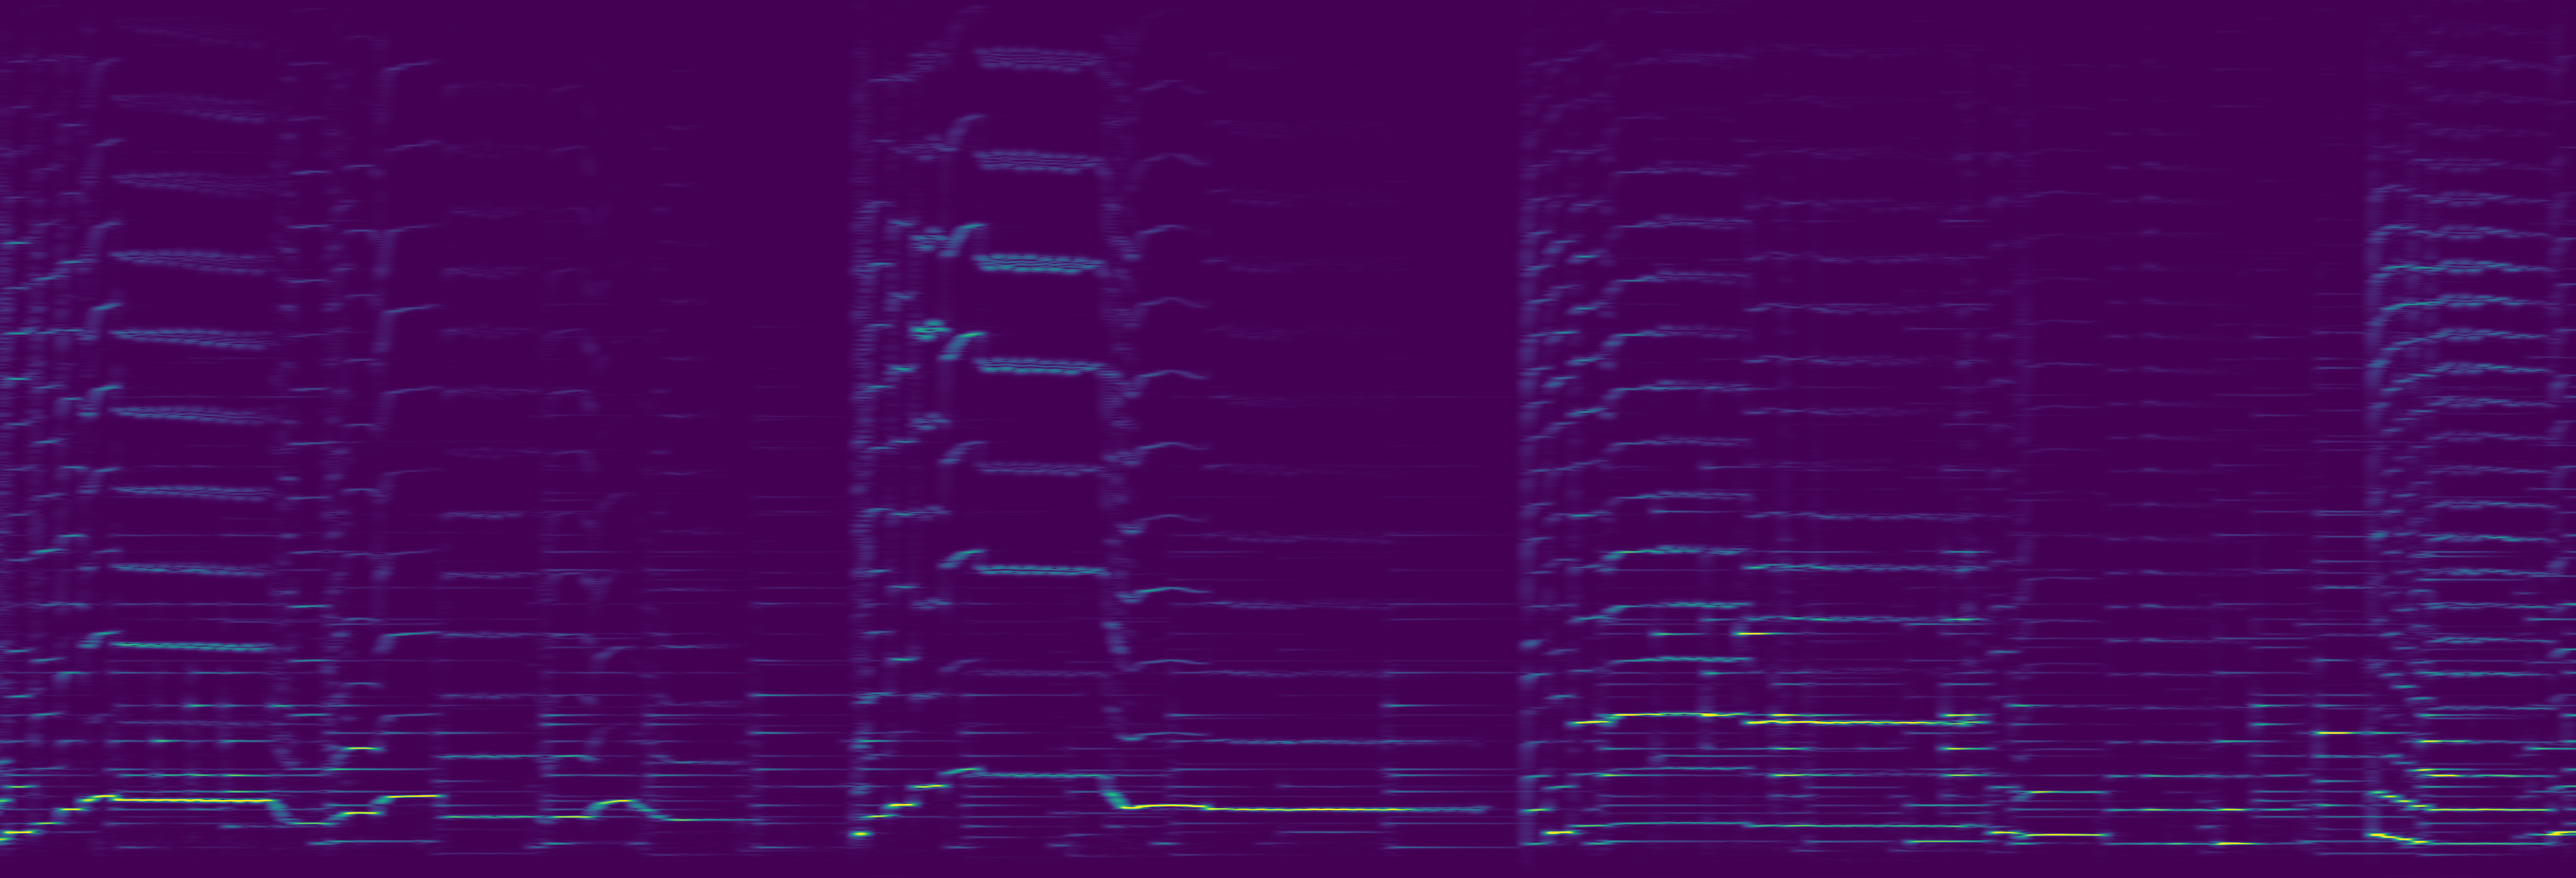

In [38]:
display(savePath);
DisplayImage(savePath);

#### Mel Spectrogram

*Skipping plotting of Mel-Spectrogram as Spectrogram.Net's MelSpectrogram API doesn't work with .Net Interactive.*

In [ ]:
string melSavePath = $"{Path.GetFileNameWithoutExtension(SampleAudioFilePath)}-melspectro";
PlotMelSpectrogram(sampleRate, audio, savePath);

## Machine learning

The GTZAN dataset has both audio and corresponding melspectrogram image of a file. 
For training and evaluation, we'll use the images and for prediction we'll use audio file.
Its more of Image classification problem now.
In case of audio files, we need to first generate melspectrogram and train it.

### Image Classification

We'll be working on MelSpectrogram images of audio files. Its present under 'images_original' folder. A pre-trained CNN architecture is used to classify the images as per Genre.

#### Prepare Dataset

In [43]:
display(AudioImagesFilePath);

D:\test\SoundClassificationMLNet\gtzan-dataset-music-genre-classification\Data\images_original

##### Split Dataset : Train/Test/Val : 70/20/10

In [53]:
SplitDataset(AudioImagesFilePath, classes.ToArray());

Unhandled exception: System.ArgumentException: Offset and length were out of bounds for the array or count is greater than the number of elements from index to the end of the source collection.
   at System.Collections.Generic.List`1.GetRange(Int32 index, Int32 count)
   at Submission#53.SplitDataset(String directory, String[] labels)
   at Submission#61.<<Initialize>>d__0.MoveNext()
--- End of stack trace from previous location ---
   at Microsoft.CodeAnalysis.Scripting.ScriptExecutionState.RunSubmissionsAsync[TResult](ImmutableArray`1 precedingExecutors, Func`2 currentExecutor, StrongBox`1 exceptionHolderOpt, Func`2 catchExceptionOpt, CancellationToken cancellationToken)

### Load Dataset

#### Data Classes

In [61]:
public struct ImageSettings
{
    public const int Height = 288;
    public const int Width = 432;
}

In [62]:
public class ModelInput
{
    [ImageType(ImageSettings.Height, ImageSettings.Width)]
    public Bitmap ImageSource { get; set; }
}

In [63]:
public class ModelOutput
{
    [ColumnName("modelOutput")]
    public float[] Score { get; set; }
}

In [ ]:
public class ImageData
{
    [LoadColumn(0)]
    public string ImagePath;

    [LoadColumn(1)]
    public string Label;
}

In [ ]:
public class ImagePrediction : ImageData
{
    public float[] Score;

    public string PredictedLabelValue;
}

#### Build MLContext

In [64]:
var mlContext = new MLContext(seed: 1);
var emptyInput = new List<ModelInput>();
var data = mlContext.Data.LoadFromEnumerable(emptyInput);

Unhandled exception: System.ArgumentOutOfRangeException: Could not determine an IDataView type and registered custom types for member ImageSource (Parameter 'rawType')
   at Microsoft.ML.Data.InternalSchemaDefinition.GetVectorAndItemType(String name, Type rawType, IEnumerable`1 attributes, Boolean& isVector, Type& itemType)
   at Microsoft.ML.Data.InternalSchemaDefinition.GetVectorAndItemType(MemberInfo memberInfo, Boolean& isVector, Type& itemType)
   at Microsoft.ML.Data.SchemaDefinition.Create(Type userType, Direction direction)
   at Microsoft.ML.Data.InternalSchemaDefinition.Create(Type userType, Direction direction)
   at Microsoft.ML.Data.DataViewConstructionUtils.CreateFromEnumerable[TRow](IHostEnvironment env, IEnumerable`1 data, SchemaDefinition schemaDefinition)
   at Microsoft.ML.DataOperationsCatalog.LoadFromEnumerable[TRow](IEnumerable`1 data, SchemaDefinition schemaDefinition)
   at Submission#72.<<Initialize>>d__0.MoveNext()
--- End of stack trace from previous location ---
   at Microsoft.CodeAnalysis.Scripting.ScriptExecutionState.RunSubmissionsAsync[TResult](ImmutableArray`1 precedingExecutors, Func`2 currentExecutor, StrongBox`1 exceptionHolderOpt, Func`2 catchExceptionOpt, CancellationToken cancellationToken)


(2,27): error CS0246: The type or namespace name 'ModelInput' could not be found (are you missing a using directive or an assembly reference?)



Cell not executed: compilation error

## References
- [Spectrogram](https://github.com/swharden/Spectrogram/)
- [NAudio](https://github.com/naudio/NAudio)
- [ML.Net](https://github.com/dotnet/machinelearning)
- [VoiceNET Library](https://github.com/nhannt201/VoiceNET.Library)
- [Tips and tricks for C# Jupyter notebook](https://ewinnington.github.io/posts/jupyter-tips-csharp)
